In [2]:
# Skip cell (weird vscode bug)

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from objectives import *
import copy
from pebsi.processing.plotting_fxns import *
import pebsi.processing.gridsearch_processing as gsproc
import pebsi.processing.gridsearch_plotting as gsplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# ===== GET RESULTS DICT =====
# gsproc.process_run('long', sites='all')                  # This function re-creates each individual run .pkl and thus takes ~60 minutes in series
result_dict = gsproc.get_result_dict(force_redo=False)                      # Add force_redo=True to recompile the result dictionaries

In [5]:
# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['2024','snowdensity','winter','summer','snowdepth','annual']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims)

In [6]:
# ===== DEFINE LIST OF ERRORS TO PERFORM CALIBRATION =====
error_list = ['summer','winter','snowdensity','snowdepth']

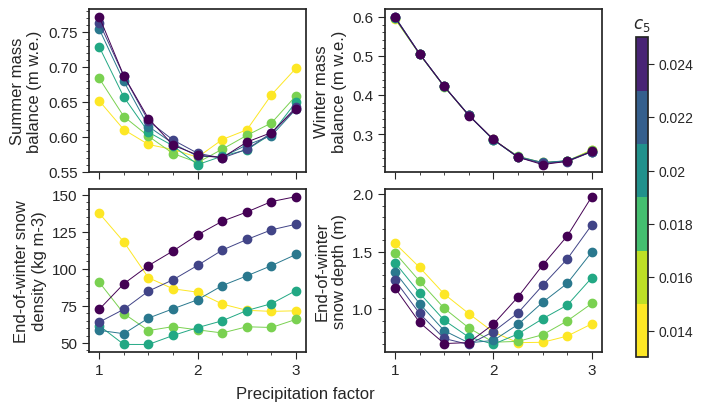

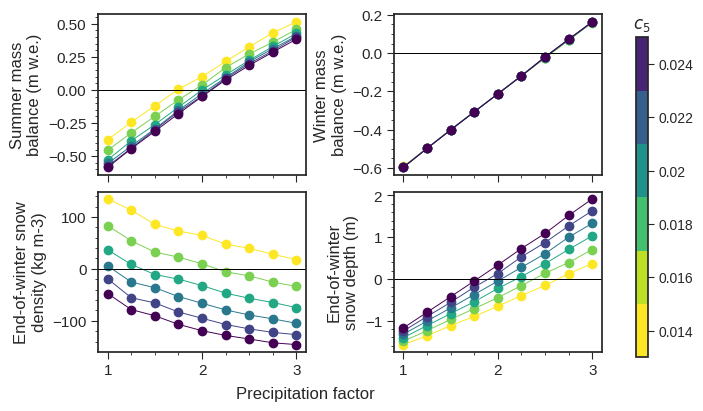

In [7]:
# ===== MULTI-PANEL TRADEOFFS =====
site = 'mean'
gsplot.plot_tradeoffs(result_dict,error_list,savefig=True,site=site)
gsplot.plot_tradeoffs(result_dict,error_list,metric='ME',savefig=True,site=site)

In [8]:
# ===== FIND PARETO FRONTS AND PLOT AN EXAMPLE =====
fp_pickle = 'pebsi/processing/pareto_results_08_01.pkl'
if not os.path.exists(fp_pickle):
    all_bootstrap_pareto, all_calib, all_valid, optima = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, error_list, return_validation=True, return_optima=True)
    all_pareto_flat = list(set(list(itertools.chain(*all_bootstrap_pareto))))
    pareto_results = {'all_pareto_flat':all_pareto_flat,
                        'all_pareto':all_bootstrap_pareto,
                        'all_calib':all_calib,
                        'all_valid':all_valid,
                        'optima':optima}
    # pickle dict
    with open(fp_pickle,'wb') as f:
        pickle.dump(pareto_results, f)
else:
    # open pickle dict
    with open(fp_pickle,'rb') as f:
        pareto_results = pickle.load(f)
        all_pareto_flat = pareto_results['all_pareto_flat']
        all_bootstrap_pareto = pareto_results['all_pareto']
        all_calib = pareto_results['all_calib']
        all_valid = pareto_results['all_valid']
        optima = pareto_results['optima']
        f.close()

/trace/home/cvwilson/research/PEBSI/pebsi/processing/gridsearch_processing.py:461: RuntimeWarning: Mean of empty slice
  site_value = np.nanmean(site_error[subset])


One iteration takes 0.10 seconds


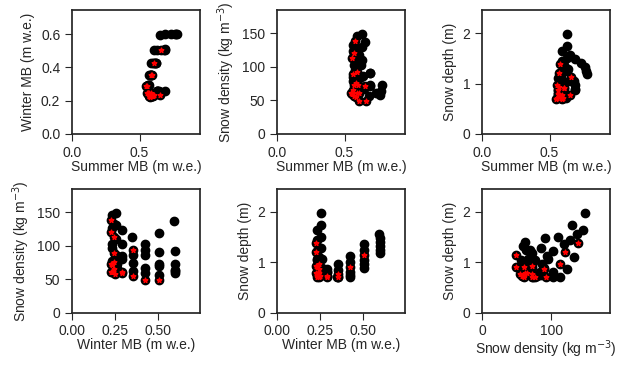

In [10]:
gsplot.plot_pareto_fronts(error_list, result_dict, split=1, savefig=True)

In [9]:
fp_pickle_seasonal = 'pebsi/processing/pareto_results_08_01_seasonal.pkl'
if not os.path.exists(fp_pickle_seasonal):
    all_bootstrap_pareto_seasonal = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, ['summer','winter'])
    frequency_dict_seasonal, _ = gsproc.get_frequency(all_bootstrap_pareto_seasonal)

    all_bootstrap_pareto_annual = gsproc.get_pareto_fronts_bootstrap(1000, result_dict, ['annual'])
    frequency_dict_annual, _ = gsproc.get_frequency(all_bootstrap_pareto_annual)

    pareto_results = {'all_pareto_seasonal':all_bootstrap_pareto_seasonal,
                            'frequency_seasonal':frequency_dict_seasonal,
                            'all_pareto_annual':all_bootstrap_pareto_annual,
                            'frequency_annual':frequency_dict_annual}

    # pickle dict
    with open(fp_pickle_seasonal,'wb') as f:
        pickle.dump(pareto_results, f)
else:
    # open dict
    with open(fp_pickle_seasonal,'rb') as f:
        pareto_results = pickle.load(f)
        all_bootstrap_pareto_seasonal = pareto_results['all_pareto_seasonal']
        frequency_dict_seasonal = pareto_results['frequency_seasonal']
        all_bootstrap_pareto_annual = pareto_results['all_pareto_annual']
        frequency_dict_annual = pareto_results['frequency_annual']
        f.close()

In [10]:
# ===== WEIGHT AND FIND THE BEST =====
best_by = gsproc.get_best_normalized(error_list, result_dict, prints=True, site='mean')
best = best_by[-1]

Weights:
    summer     winter snowdensity  snowdepth     best
         1          0          0          0      ('0.018', '2')
         0          1          0          0      ('0.024', '2.5')
         0          0          1          0      ('0.018', '1.5')
         0          0          0          1      ('0.022', '1.75')
      0.25       0.25       0.25       0.25      ('0.016', '2.25')


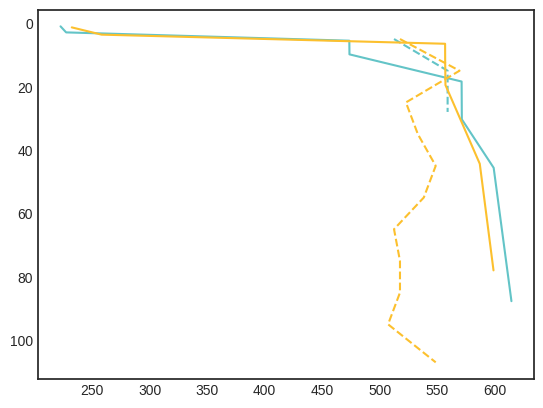

In [37]:
dsd = gsproc.get_any(result_dict, '0.016', '2.25', site='D', run_type='2024')
dst = gsproc.get_any(result_dict, '0.016', '2.25', site='T', run_type='2024')
pitsd = pd.read_csv('../MB_data/Point/gulkana/pitcore/Gulkana2024.08.21_Pit_D.csv')
pitst = pd.read_csv('../MB_data/Point/gulkana/pitcore/Gulkana2024.08.20_Pit_T.csv')
fig,ax = plt.subplots()
for s,site in enumerate(['D','T']):
    if site == 'D':
        pit = pitsd
        ds = dsd
        date = pd.to_datetime('2024-08-21 14:00')
    else:
        pit = pitst
        ds = dst
        date = pd.to_datetime('2024-08-20 14:00')
    # modeled density
    ds = ds.isel(time=-1)
    grainsize = ds.layergrainsize.values
    lh = ds.layerheight.values[grainsize < 1999]
    depth_mod = np.array([np.sum(lh[:i+1])-(lh[i]/2) for i in range(len(lh))]) * 100
    dens_mod = ds.layerdensity.values[grainsize < 1999]
    
    # measured density
    depth_meas = pit['sample_bottom_depth'].values - 5
    dens_meas = pit['sample_weight'].values / pit['volume'].values * 1000
    ax.plot(dens_mod, depth_mod, color = gsproc.all_colors[s])
    ax.plot(dens_meas, depth_meas, color = gsproc.all_colors[s], linestyle='--')
ax.invert_yaxis()

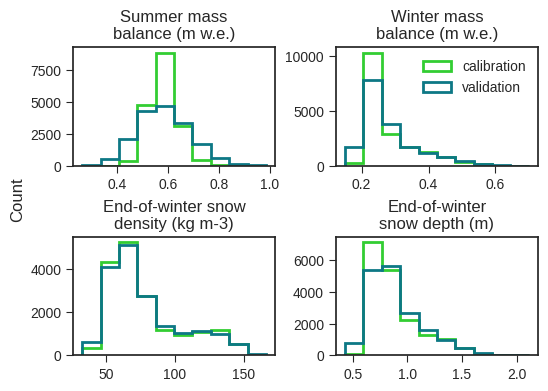

In [44]:
# ===== COMPARE VALIDATION TO CALIBRATION =====
gsplot.compare_calib_valid(error_list, all_calib, all_valid, savefig=True)

hard coded max frequency
hard coded max frequency
hard coded max frequency
hard coded max frequency


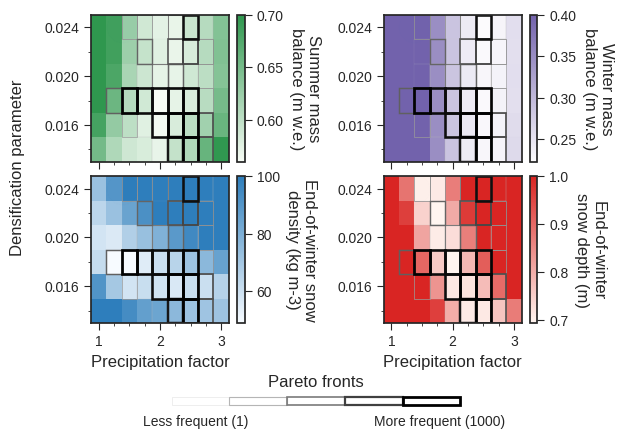

hard coded max frequency
hard coded max frequency
hard coded max frequency
hard coded max frequency


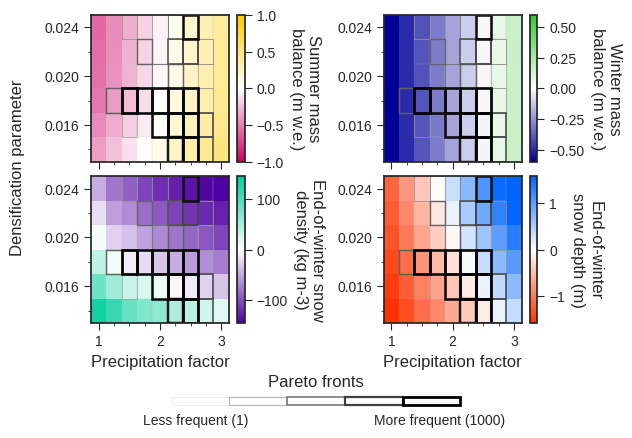

In [7]:
frequency_dict, _ = gsproc.get_frequency(all_bootstrap_pareto)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='MAE', optima=optima)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='ME', optima=optima)

hard coded max frequency
hard coded max frequency
hard coded max frequency


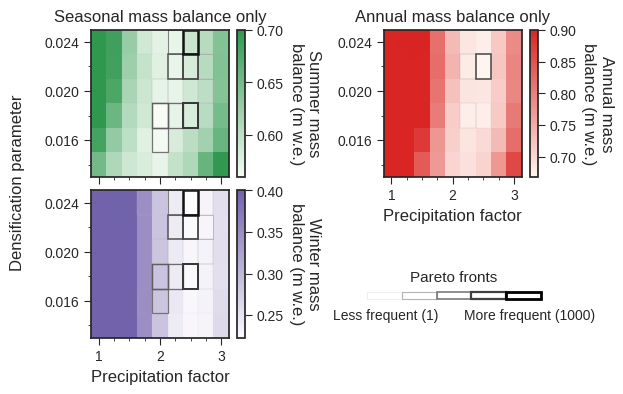

In [16]:
# 2x2 PLOT
fig = plt.figure(figsize=(6,4))
gs = mpl.gridspec.GridSpec(4,2, figure=fig, wspace=0.7, hspace=0.2)

# Generate subplots for seasonal 
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax_left = [ax1,ax2]
# Plot heatmap
fig, ax_left = gsplot.plot_pareto_heatmap(frequency_dict_seasonal, result_dict, ['summer','winter'], savefig=False, metric='MAE', figaxes = (fig, ax_left), legend=False)
# Labeling
ax_left[0].set_xticklabels(['','',''])
ax_left[0].set_title('Seasonal mass balance only', fontsize=12)
ax_left[1].set_title('')
ax_left[1].set_xlabel('Precipitation factor', fontsize=12)

# Generate subplot for annual
ax_right = fig.add_subplot(gs[0:2, 1])
# Plot heatmap
fig, ax_right = gsplot.plot_pareto_heatmap(frequency_dict_annual, result_dict, ['annual'], savefig=False, metric='MAE', figaxes = (fig, [ax_right]), legend=False)
# Labeling
ax_right[0].set_title('Annual mass balance only', fontsize=12)
ax_right[0].set_xlabel('Precipitation factor', fontsize=12)

cax = fig.add_axes([0.58,0.2,0.3,0.03])
cmap = mpl.colormaps['Grays']
norm =  mpl.colors.Normalize(vmin=0,vmax=5)
boundaries = [1,2,3,4,5]
for b in boundaries:
    alpha = 1 - (5 - b)/5
    rect = mpl.patches.Rectangle((b, 0), 1, 1, linewidth=alpha*2, edgecolor=cmap(norm(b)), facecolor='none')
    cax.add_patch(rect)
border = 0.1
cax.set_xlim(np.min(boundaries) - border, np.max(boundaries) + 1 + border)
cax.set_ylim(-0.3,1.3)
cax.axis('off')
cax.text(0, -2.7, 'Less frequent (1)')
cax.text(3.8, -2.7, 'More frequent (1000)')
cax.set_title('Pareto fronts',fontsize=11)
fig.supxlabel('')

plt.savefig('/trace/group/rounce/cvwilson/Output/seasonal_annual_only_calibration.png', dpi=250, bbox_inches='tight')

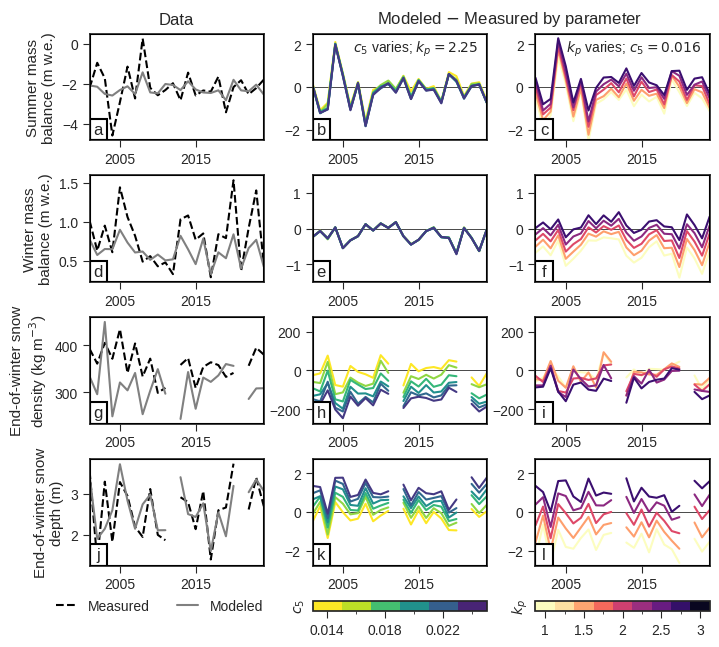

In [7]:
# ===== TRADEOFFS TIMESERIES=====
gsplot.plot_difference_by_param(best, result_dict, plot_vars=error_list, savefig=True, include_best=True)

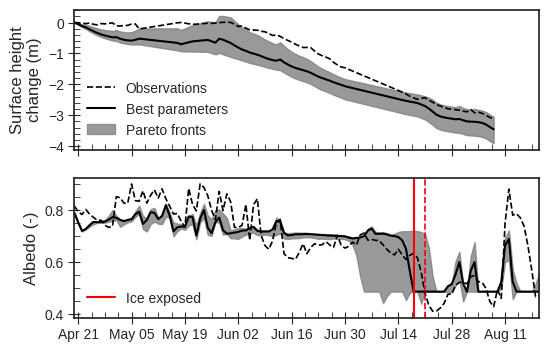

In [21]:
site = 'B'
fig, axes = plt.subplots(2, figsize=(6,4), gridspec_kw={'wspace':0.25}, sharex='col')

ax = axes[0]
all_timeseries = {'dh':[], 'albedo':[]}
for (c5,kp) in all_pareto_flat:
    dates_dh = result_dict[c5][kp][site]['dates']
    dh_mod = result_dict[c5][kp][site]['dh_mod']
    dates_albedo = result_dict[c5][kp][site]['albedo_dates']
    albedo_mod = result_dict[c5][kp][site]['albedo_mod']
    all_timeseries['dh'].append(dh_mod)
    all_timeseries['albedo'].append(albedo_mod)
min_series = np.min(np.array(all_timeseries['dh']), axis=0)
max_series = np.max(np.array(all_timeseries['dh']), axis=0)
dh_best =  result_dict[best[0]][best[1]][site]['dh_mod']
dh_data = result_dict[best[0]][best[1]][site]['dh_meas']
ax.plot(dates_dh, dh_data, color='black',linestyle='--', linewidth=1.2,label='Observations')
ax.plot(dates_dh, dh_best, color='k', linewidth=1.5, label='Best parameters')
ax.fill_between(dates_dh, min_series, max_series, alpha=0.8, color='gray', label='Pareto fronts')
ax.tick_params(labelsize=10,direction='inout',length=8)

ax.minorticks_on()
ax.tick_params(which='minor', direction='in', length=4)
ax.legend()
ax.set_ylabel('Surface height\nchange (m)', fontsize=12)

# ALBEDO TIMESERIES
ax = axes[1]
min_series = np.min(np.array(all_timeseries['albedo']), axis=0)
max_series = np.max(np.array(all_timeseries['albedo']), axis=0)
albedo_best =  result_dict[best[0]][best[1]][site]['albedo_mod']
albedo_data = result_dict[best[0]][best[1]][site]['albedo_meas']

# Plot albedo
ax.plot(dates_albedo, albedo_data, color='k',linestyle='--', linewidth=1.2) #, label='Observations')
ax.plot(dates_albedo, albedo_best, color='k', linewidth=1.5) #,label='Best parameters')
ax.fill_between(dates_albedo, min_series, max_series, alpha=0.8, color='gray')
# Plot ice exposure date
when_modeled = dates_albedo[np.where(np.abs(albedo_best - np.min(albedo_best)) < 0.05)[0][0]]
when_measured = pd.to_datetime('2024-07-21')
ax.axvline(when_modeled, color='r', linewidth=1.5,label='Ice exposed')
ax.axvline(when_measured, color='r', linestyle='--', linewidth=1.2)
ax.legend()
# ax.legend()
ax.set_xlim(dates_albedo[0],dates_albedo[-1])
ax.set_ylabel('Albedo (-)', fontsize=12)
ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='2W'))
ax.tick_params(labelsize=10,direction='inout',length=8)
ax.minorticks_on()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
ax.tick_params(which='minor', direction='in', length=4)
# ax.set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'],fontsize=11)
# ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(interval=7))


# ax.tick_params(length=5)
# axes[0].set_title('Timeseries',fontsize=12)
axes = axes.flatten()


# fig.suptitle('Validation of Pareto fronts on the 2024 melt season',fontsize=12,y=1)
plt.savefig(gsproc.base_fp+'poster_2024_pareto_comparison.png',bbox_inches='tight',dpi=300)
plt.show()

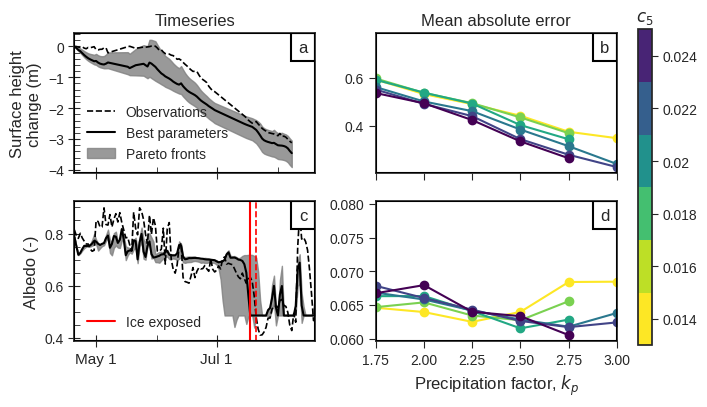

In [15]:
# ===== PLOT 2024 PARETO FRONT VALIDATION =====
gsplot.plot_pareto_2024(all_pareto_flat, result_dict, frequency_dict, best, savefig=True)

In [49]:
# ===== TRADEOFFS TIMESERIES FOR ONE RUN TYPE =====
# gsplot.plot_tradeoffs_2024(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_annual(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_snowpits(result_dict, best_by[-1])

A 0.5141038311267938
AU 0.25589699185173886
B 0.33751853597222614
D 0.5485323947629068
mean 0.4140129384284163
0.46956442936137716 0.44651325911865103


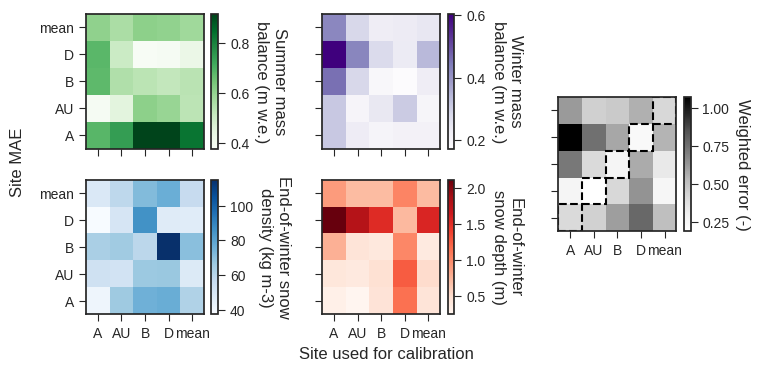

A 0.5141038311267938
AU 0.25589699185173886
B 0.33751853597222614
D 0.5485323947629068
mean 0.4140129384284163
0.46956442936137716 0.44651325911865103


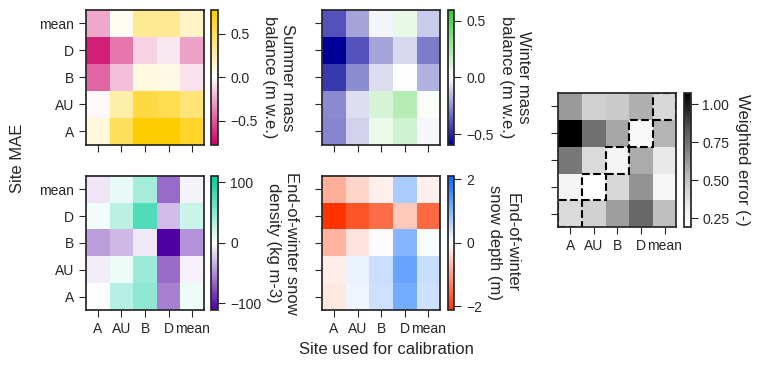

In [50]:
# ===== CALIBRATE ON ONE SITE =====
# gsplot.plot_heatmap_by_site(error_list, result_dict)
# gsplot.plot_best_by_site(error_list, result_dict)
error_list_heatmap = error_list + ['weighted']
gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='MAE', savefig=True)
gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='ME', savefig=True)

In [51]:
# ===== PLOT A SINGLE RUN =====
# gsplot.plot_best_seasonal(best, result_dict, savefig=True)
# gsplot.plot_best_2024(best, result_dict, savefig=True)
# gsplot.plot_best_snowpits(best_by[-1], result_dict, savefig=True)
# gsplot.plot_best_snowmass(best_by[-1], result_dict) 
# gsplot.plot_best_albedo(best, result_dict, savefig=True)

AU -3.09 og 1.063421957824477 bc -0.10765332740856026 aws 0.06582187500656156
AB -2.96 og 1.4778243015508705 bc 0.45289133550228744 aws 0.3293472339771202
B -1.79 og 0.5856797972898491 bc -0.2743168167830867 aws -0.17249707047965424
D -1.19 og 0.45185281915505604 bc 0.08653074632414492 aws 0.2184763284666721
T -1.0299999999999998 og 0.16292218618181242 bc -0.19603226037555022 aws -0.06309477655354567
og 0.7483402124004129 bc 0.22348489727872592 aws 0.16984745689671074


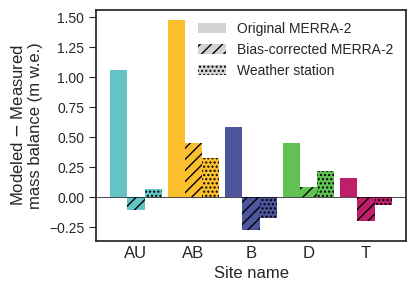

In [62]:
with open('/trace/group/rounce/cvwilson/Output/bias_correct/bias_correction_test.pkl', 'rb') as f:
    mb_dict = pickle.load(f)
gsplot.plot_bias_correction(mb_dict, True)

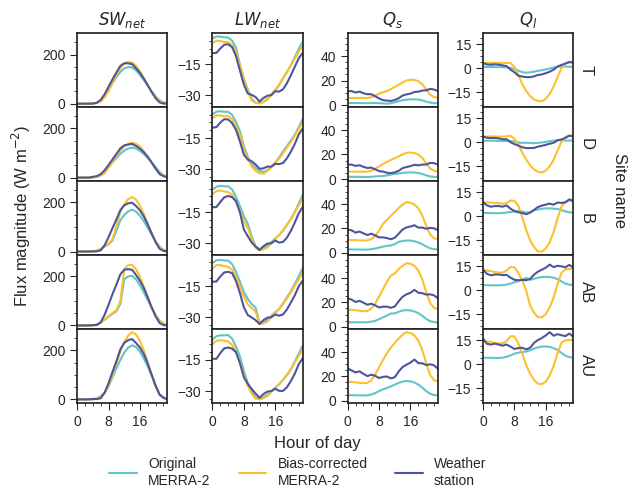

In [16]:
gsplot.plot_fluxes(savefig=True)

0.0011806776822974462


np.float64(0.001293037376728132)

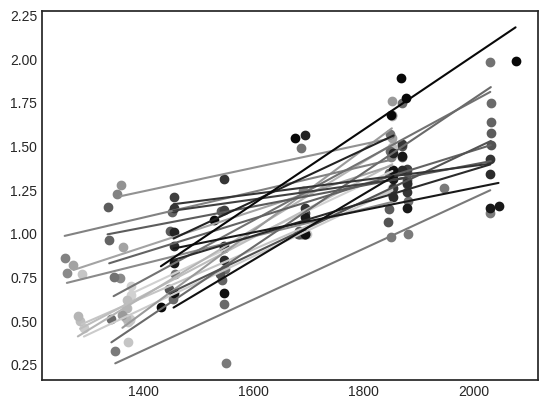

In [19]:
gsplot.find_precip_gradient()

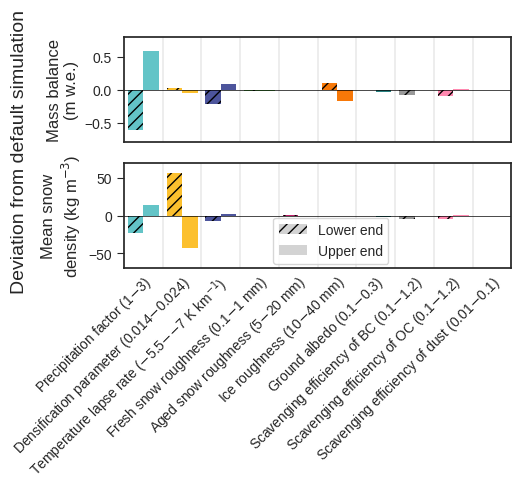

In [29]:
sensitivity_fp = '/trace/group/rounce/cvwilson/Output/sensitivity/sensitivity_test.pkl'
if not os.path.exists(sensitivity_fp):
    sens_dict = {}
    fp = '/trace/group/rounce/cvwilson/Output/sensitivity/'
    def get_mb(fn):
        ds = xr.open_dataset(fn)
        summer_mb = ds.accum + ds.refreeze - ds.melt
        ds.close()
        return summer_mb.sum().values
    def get_dens(fn):
        ds = xr.open_dataset(fn)
        all = []
        for t in ds.time.values:
            density = ds.sel(time=t).layerdensity.values
            height = ds.sel(time=t).layerheight.values
            where = np.where(density < 899)[0]
            avg = np.sum(density[where]*height[where] / np.sum(height[where]))
            all.append(avg)
        avg = np.mean(all)
        ds.close()
        return avg
    sens_dict['base'] = {}
    sens_dict['base']['base'] = {}
    sens_dict['base']['base']['mb'] = get_mb(fp + 'base_0.nc')
    sens_dict['base']['base']['density'] = get_dens(fp + 'base_0.nc')

    for var in ['kp','Boone-c5','lapserate','roughness-fresh-snow','roughness-aged-snow','roughness-ice','albedo-ground','ksp-BC','ksp-OC','ksp-dust']:
        sens_dict[var.replace('-','_')] = {}
        for direction in ['+20','-20']:
            sens_dict[var.replace('-','_')][direction] = {}
            sens_dict[var.replace('-','_')][direction]['mb'] = get_mb(f'{fp}{var}_{direction}_0.nc') 
            sens_dict[var.replace('-','_')][direction]['density'] = get_dens(f'{fp}{var}_{direction}_0.nc') 
    with open(sensitivity_fp,'wb') as f:
        pickle.dump(sens_dict, f)
else:
    with open(sensitivity_fp,'rb') as f:
        sens_dict = pickle.load(f)

gsplot.plot_sensitivity(sens_dict, savefig=True)

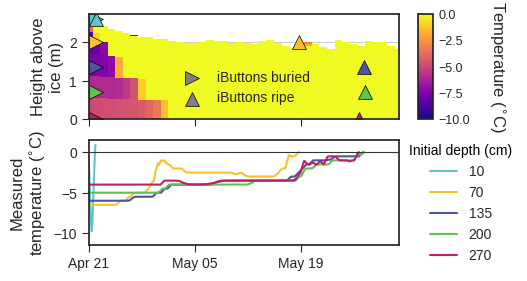

In [16]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
site = 'B'
ripe_dates = {}
colors = ['#63c4c7','#fcc02e','#4D559C','#60C252','#BF1F6A']

ds = gsproc.get_any(result_dict, best[0],best[1],site,'2024')
fig, axes = plt.subplots(2,1,figsize=(5,3),sharex=True)
(ax1,ax2) = axes

if site =='D':
    axes[0] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'], plot_ax=[axes[0]])[0] #,plot_firn=False)
else:
    axes[0] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],plot_ax=[axes[0]])[0]
# Scatter initial heights of iButtons
depths = np.array([f for f in ripe_dict[site]])
heights = depths[-1] - depths
start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
ms=100
if site == 'D':
    heights += 700
for c in range(len(heights)):
    ax1.scatter(start[c],heights[c]/100,marker='>',color=colors[c],s=ms,edgecolor='k',linewidth=0.5,)
ax1.scatter(np.nan,np.nan,color='gray',marker='>',label='iButtons buried',s=ms,edgecolor='k',linewidth=0.5,)

# Scatter ripened dates for each sensor
for c,depth in enumerate(ripe_dict[site]):
    if site != 'B':
        height = 150 - depth
    else:
        height = 270 - depth
    if site == 'D':
        height += 700
    ax1.scatter(ripe_dict[site][depth],height/100,marker='^',s=ms,color=colors[c],edgecolor='k',linewidth=0.5,)
ax1.scatter(np.nan,np.nan,marker='^',color='gray',s=ms,edgecolor='k',linewidth=0.5,label='iButtons ripe')
ax1.set_ylabel('Height above\nice (m)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.5,0.3), loc='center')

# Add lineplot of temperatures
df = pd.read_csv('/trace/home/cvwilson/research/data/iButtons_2024_B.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df = df.resample('h').mean()
for c,col in enumerate(df.columns):
    values = df.loc[:list(ripe_dict[site].values())[c]]
    ax2.plot(values.index, values[col].values,color=colors[c],label=list(ripe_dict[site])[c])
leg = ax2.legend(title='Initial depth (cm)',loc='center',bbox_to_anchor=(1.2,0.4))
leg.get_title().set_color('black')
ax2.axhline(0,color='0.2',linewidth=0.8)
ax2.tick_params(length=5)
ax2.set_xticks(pd.date_range('2024-04-01','2024-08-01',freq='2W'))
ax2.set_ylabel('Measured\ntemperature ($^{\circ}$C)',fontsize=12)

for ax in [ax1,ax2]:
    ax.set_xlim(pd.to_datetime('2024-04-21'), pd.to_datetime('2024-06-01'))

pos1 = ax1.get_position()
ax2.set_position([pos1.x0, ax2.get_position().y0, pos1.width, ax2.get_position().height])

plt.savefig(gsproc.base_fp+'snow_temperature.png',dpi=200,bbox_inches='tight')
plt.show()

In [56]:
all_r2 = []
params = best
for site in gsproc.sitedict['2024'][1:]: #['ABB','B','BD','T']: # 
    site_all = []
    for params in all_pareto_flat:
        dh_mod = result_dict[params[0]][params[1]][site]['dh_mod']
        dh_meas = result_dict[params[0]][params[1]][site]['dh_meas']
        ss_tot = np.sum((dh_meas - np.mean(dh_meas)) ** 2)
        ss_res = np.sum((dh_meas - dh_mod) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        site_all.append(r_squared)
        # if r_squared > 0.7:
        #     print(params, r_squared)
    print(site, np.median(site_all), np.min(site_all), np.max(site_all))
    all_r2.append(site_all)
print(np.median(all_r2), np.min(all_r2), np.max(all_r2))

ABB 0.8975252172019273 0.7510511937597072 0.9681479806021145
B 0.7790962285385741 0.4846214926079522 0.9504988152143471
BD 0.9286624755338376 0.8003676572548049 0.982667046223858
D 0.7230433553533883 -1.8080714514497824 0.993252653218655
T 0.08277371896895092 -1.0772126969301756 0.6658866566870509
0.601464778140995 -1.8080714514497824 0.993252653218655


In [58]:
all_r2 = []
params = best
for site in gsproc.sitedict['2024'][1:]: #['ABB','B','BD','T']: # 
    
    dh_mod = result_dict[params[0]][params[1]][site]['dh_mod']
    dh_meas = result_dict[params[0]][params[1]][site]['dh_meas']
    ss_tot = np.sum((dh_meas - np.mean(dh_meas)) ** 2)
    ss_res = np.sum((dh_meas - dh_mod) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    all_r2.append(r_squared)
    print(site, r_squared)
print(np.median(all_r2), np.min(all_r2), np.max(all_r2))

ABB 0.895621044901858
B 0.7739742666776104
BD 0.9150505506859927
D 0.17324884928865514
T 0.02986548884572915
0.7739742666776104 0.02986548884572915 0.9150505506859927


In [36]:
f= []
for (c5,kp) in all_pareto_flat:
    f.append(result_dict[c5][kp]['B']['summer_MAE'])
print(np.mean(f))

0.5786784064547058


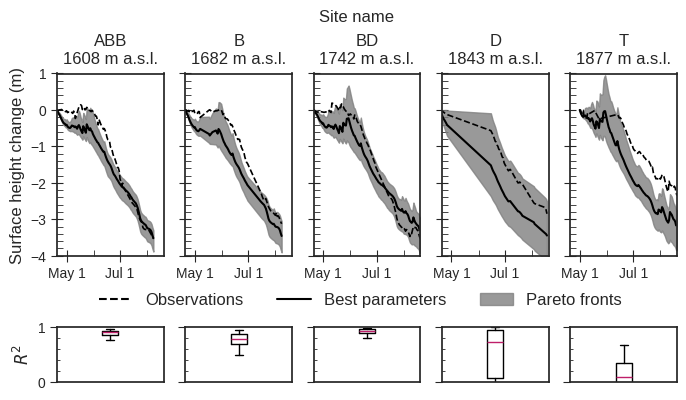

In [54]:
# gsplot.plot_best_2024_dh(best, result_dict)
gsplot.plot_pareto_2024_dh(result_dict, all_pareto_flat, best,savefig=True)

['Liberation Sans']


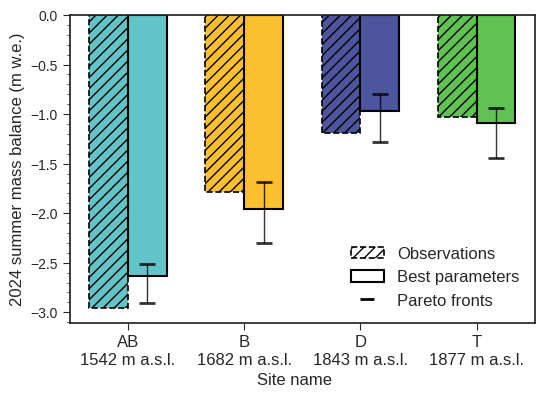

In [55]:
gsplot.plot_pareto_2024_mb(result_dict, all_pareto_flat, best, savefig=True)

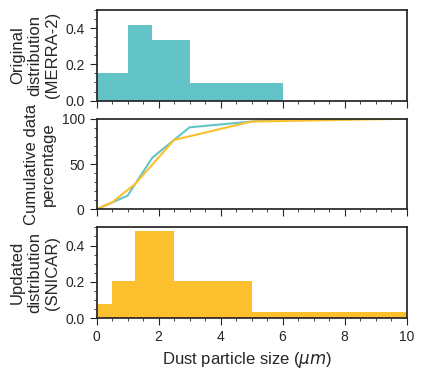

In [ ]:
y_snicar = [0.0751, 0.20535, 0.481675, 0.203775, 0.034]
y_merra = [0.150, 0.41944444444444456, 0.3354111111111112, 0.0952222222,0]
bins_snicar = [0,0.5,1.25,2.5,5,10]
bins_merra = [0,1,1.8,3,6,10]

percent_merra = np.append(np.array([0]), np.cumsum(y_merra) * 100)
percent_snicar = np.interp(bins_snicar, bins_merra, percent_merra)

fig, axes = plt.subplots(3,1,sharex=True, figsize=(4,4))

ax = axes[0]
width_merra = np.array(bins_merra[1:]) - np.array(bins_merra[:-1])
ax.bar(bins_merra[:-1], y_merra, align='edge', width=width_merra, color = gsplot.all_colors[0])
ax.set_ylabel('Original\ndistribution\n(MERRA-2)',fontsize=12)

ax = axes[1]
ax.plot(bins_merra, percent_merra, color=gsplot.all_colors[0])
ax.plot(bins_snicar, percent_snicar, color=gsplot.all_colors[1])
ax.set_ylabel('Cumulative data\npercentage',fontsize=12)

ax = axes[2]
width_snicar = np.array(bins_snicar[1:]) - np.array(bins_snicar[:-1])
ax.bar(bins_snicar[:-1], y_snicar, align='edge', width=width_snicar, color = gsplot.all_colors[1])
ax.set_xlim(0,10)
ax.set_ylabel('Updated\ndistribution\n(SNICAR)',fontsize=12)

for a,ax in enumerate(axes):
    ax.tick_params(length=5,labelsize=10)
    if a != 1:
        ax.set_ylim(0,0.5)
    else:
        ax.set_ylim(0,100)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.minorticks_on()
    ax.tick_params(which='minor', length=2)
fig.supxlabel('Dust particle size ($\mu m$)',y=-0.02)
plt.savefig('/trace/group/rounce/cvwilson/Output/dust_fig.png',dpi=300, bbox_inches='tight')
plt.show()

# REVIEW
## NUMBERS

In [48]:
for site in ['A','T']:
    # print(result_dict['0.016']['2.5'][site]['summer_meas'])
    USGS_fp = '../MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
    df_mb = pd.read_csv(USGS_fp)
    df_mb = df_mb.loc[df_mb['site_name'] == site]
    df_mb.index = df_mb['Year']
    years = df_mb.index
    df_mb = df_mb.loc[years]
    this_winter_abl_data = df_mb['winter_ablation'].iloc[1:].values
    past_summer_acc_data = df_mb['summer_accumulation'].iloc[:-1].values
    this_summer_acc_data = df_mb['summer_accumulation'].iloc[1:].values
    past_summer_acc_data[np.isnan(past_summer_acc_data)] = 0
    this_summer_acc_data[np.isnan(this_summer_acc_data)] = 0
    this_winter_abl_data[np.isnan(this_winter_abl_data)] = 0
    winter_data = df_mb['bw'].iloc[1:] - past_summer_acc_data + this_winter_abl_data
    summer_data = df_mb['ba'].iloc[1:] - df_mb['bw'].iloc[1:] + this_summer_acc_data
    annual_data = winter_data + summer_data
    print(site, 'summer', np.mean(summer_data),'winter', np.mean(winter_data))

A summer -3.806595744680851 winter 0.2545833333333334
T summer -1.1157142857142859 winter 1.3924999999999998


In [53]:
all_B_MAE = []
for c5, kp in all_pareto_flat:
    all_B_MAE.append(result_dict[c5][kp]['B']['albedo_MAE'])
print('ALBEDO', np.mean(all_B_MAE))

all_B_MAE = []
for c5, kp in all_pareto_flat:
    all_B_MAE.append(result_dict[c5][kp]['B']['2024_MAE'])
print('DH',np.mean(all_B_MAE))

ALBEDO 0.06567713791790723
DH 0.4828441434115403


## FIGURES

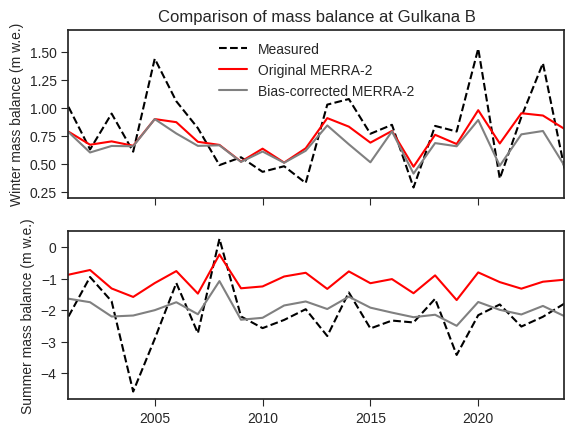

In [160]:
ds_corrected = gsproc.get_any(result_dict, best[0], best[1], 'B')
ds_un = xr.open_dataset('/trace/group/rounce/cvwilson/Output/gulkanaB_no_bias_correct_1.nc') # RUNNING

years, wmod, wmeas, smod, smeas, amod, ameas = seasonal_mass_balance(ds_corrected, out='data')
years, wmodu, wmeasu, smodu, smeasu, amodu, ameasu = seasonal_mass_balance(ds_un, out='data')

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(years, wmeas, color = 'k', linestyle='--', label='Measured')
ax1.plot(years, wmodu, color = 'red', label='Original MERRA-2')
ax1.plot(years, wmod, color = 'gray', label='Bias-corrected MERRA-2')

ax2.plot(years, smeas, color = 'k', linestyle='--')
ax2.plot(years, smodu, color = 'r')
ax2.plot(years, smod, color = 'gray')

ax1.legend()
ax1.tick_params(length=5)
ax1.set_ylabel('Winter mass balance (m w.e.)')
ax2.tick_params(length=5)
ax2.set_ylabel('Summer mass balance (m w.e.)')
ax2.set_xlim(2001, 2024)
ax1.set_ylim(0.2, 1.7)
ax1.set_title('Comparison of mass balance at Gulkana B')
plt.savefig('/trace/group/rounce/cvwilson/Output/bias_correct_alltime.png', dpi=300, bbox_inches='tight')

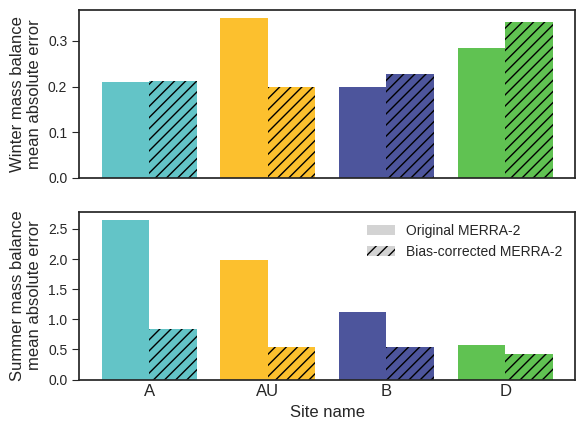

In [8]:
fig, axes = plt.subplots(2, sharex=True)
colors = all_colors
winters = {'corr':[], 'uncorr':[]}
summers = {'corr':[], 'uncorr':[]}
for s, site in enumerate(['A','AU','B','D']):
    idx = '2' if site == 'D' else '1'
    if site == 'B':
        ds_un = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/gulkana{site}_no_bias_correct_{idx}.nc')
    else:
        ds_un = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/Gulkana_2025_11_13_long{site}_nobiascorrect_{idx}.nc')

    winter_MAE = result_dict[best[0]][best[1]][site]['winter_MAE']
    summer_MAE = result_dict[best[0]][best[1]][site]['summer_MAE']
    winter_MAE_un, summer_MAE_un, _ = seasonal_mass_balance(ds_un)
    summers['corr'].append(summer_MAE)
    summers['uncorr'].append(summer_MAE_un)
    winters['corr'].append(winter_MAE)
    winters['uncorr'].append(winter_MAE_un)

    axes[0].bar(s, winter_MAE_un, 0.4, color=colors[s])
    axes[0].bar(s+0.4, winter_MAE, 0.4, color=colors[s], hatch='///')
    axes[1].bar(s, summer_MAE_un, 0.4, color=colors[s])
    axes[1].bar(s+0.4, summer_MAE, 0.4, color=colors[s], hatch='///')

axes[0].set_ylabel('Winter mass balance\nmean absolute error', fontsize=12)
axes[1].set_ylabel('Summer mass balance\nmean absolute error', fontsize=12)

for ax in axes:   
    ax.tick_params(axis='y',length=5)
    ax.set_xticks([x+0.2 for x in range(4)])
    ax.set_xticklabels(['A','AU','B','D'],fontsize=12)
    ax.axhline(0, linewidth=0.5, color='k')

ax.set_xlabel('Site name',fontsize=12)
ax.bar(np.nan, np.nan, np.nan, color='lightgray', label='Original MERRA-2')
ax.bar(np.nan, np.nan, np.nan, color='lightgray', label='Bias-corrected MERRA-2',hatch='///')
ax.legend()
plt.savefig('/trace/group/rounce/cvwilson/Output/bias_correction_comparison_longruns.png',dpi=300,bbox_inches='tight')
plt.show()

In [9]:
print(np.mean(summers['corr']), np.mean(summers['uncorr']))
print(np.mean(winters['corr']), np.mean(winters['uncorr']))

0.5822603339727634 1.584081344849102
0.24484514482085729 0.26084491226557877


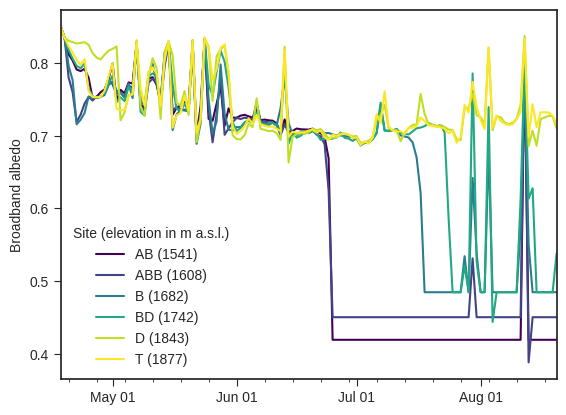

In [37]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=1541, vmax=1877)
for s, site in enumerate(['AB','ABB','B','BD','D','T']):
    ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='2024')
    elevation = float(ds.attrs['elevation'][:6])
    albedo = ds['albedo'].sel(time=pd.date_range(ds.time.values[0], ds.time.values[-1]))
    ax.plot(albedo.time, albedo.values, color=cmap(norm(elevation)), label=f'{site} ({int(elevation)})')
ax.legend(title='Site (elevation in m a.s.l.)')
ax.tick_params(length=5)
ax.tick_params(which='minor', length=2)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
ax.set_xticks(pd.date_range(albedo.time.values[0], albedo.time.values[-1], freq='MS'))
ax.set_xlim(pd.to_datetime(albedo.time.values[0]), pd.to_datetime(albedo.time.values[-1]))
ax.xaxis.set_minor_locator(mpl.dates.DayLocator(interval=7))
ax.set_ylabel('Broadband albedo')
plt.savefig('/trace/group/rounce/cvwilson/Output/albedo_by_elevation.png',dpi=300, bbox_inches='tight')
plt.show()

In [148]:
# ds_exp = xr.open_dataset('/trace/home/cvwilson/research/Output/expalbedo4.nc').resample(time='d').mean()
# ds_snicar = gsproc.get_any(result_dict, best[0], best[1], 'B', run_type='2024').resample(time='d').mean()
# ds_check = xr.open_dataset('/trace/home/cvwilson/research/Output/base.nc0.nc').resample(time='d').mean()

# fig, ax = plt.subplots()
# ax.plot(ds_exp.time, ds_exp.albedo,label='Exponential',c="#4669AC")
# ax.plot(ds_snicar.time, ds_snicar.albedo, label='SNICAR',c="#32BACC")
# ax.plot(result_dict[c5][kp]['B']['albedo_dates'], result_dict[c5][kp]['B']['albedo_meas'], label='Measured',color='k',linestyle='--')
# ax.legend()
# ax.set_ylabel('Albedo')
# ax.set_xticks(pd.date_range('2024-04-18','2024-08-18',freq='2W'))
# ax.tick_params(length=5)
# ax.set_xlim(pd.to_datetime('2024-04-18'), pd.to_datetime('2024-08-18'))
# plt.savefig()

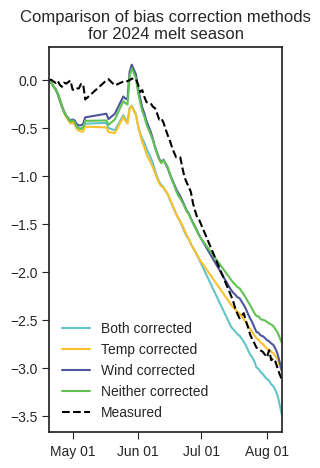

In [29]:
base_fp = '/trace/home/cvwilson/research/Output/'
ds_temp_only = xr.open_dataset(base_fp + 'temp_only_short_0.nc')
ds_wind_only = xr.open_dataset(base_fp + 'wind_only_short_0.nc')
ds_both = xr.open_dataset(base_fp + 'both_short_0.nc')
ds_neither = xr.open_dataset(base_fp + 'neither_short_0.nc')
fig, ax = plt.subplots(figsize=(3, 5))

time, dh_temp_only, dh_data = cumulative_mass_balance(ds_temp_only, out='data')
time, dh_wind_only, dh_data = cumulative_mass_balance(ds_wind_only, out='data')
time, dh_both, dh_data = cumulative_mass_balance(ds_both, out='data')
time, dh_neither, dh_data = cumulative_mass_balance(ds_neither, out='data')

ax.plot(time, dh_both, color=colors[0], label='Both corrected')
ax.plot(time, dh_temp_only, color=colors[1], label='Temp corrected')
ax.plot(time, dh_wind_only, color=colors[2], label='Wind corrected')
ax.plot(time, dh_neither, color=colors[3], label='Neither corrected')
ax.plot(time, dh_data, color='k', linestyle='--', label='Measured')
ax.legend()
ax.set_xlim(time[0], time[-1])
ax.tick_params(length=5)
ax.set_xticks(pd.date_range(time[0], time[-1], freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
ax.set_title('Comparison of bias correction methods\nfor 2024 melt season')
plt.savefig(base_fp + 'wind_vs_temp_bias_correction.png',dpi=300, bbox_inches='tight')

In [121]:
kp_by_site = {'A':{}, 'AU':{}, 'B':{}, 'D':{}}

Regression at gulkana site B using AWS precip and AWS temperature data: 
kp = 1.7513193927077606


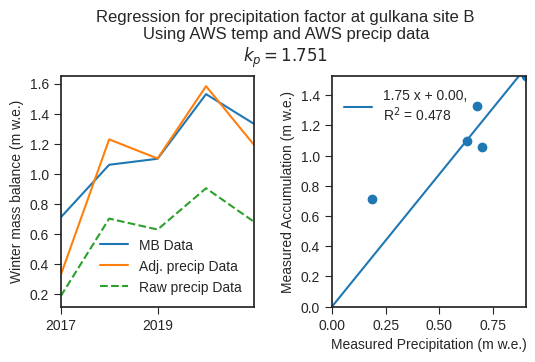

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import argparse

# INPUTS
glac_no = '01.00570'            # 09162 WOLV 22193 KAH
site = 'B'                      # Name of index site
region = glac_no[:2]
temp_dataset = 'AWS'         # MERRA2 or AWS
tp_dataset = 'AWS'           # MERRA2 or AWS
AWS_elev = 1725
temp_threshold = [0.2,2.2]      # Threshold to linearly scale rain/snow

# COMMAND LINE ARGS
parser = argparse.ArgumentParser(description='kp regressor arguments')
parser.add_argument('-site', action='store', default=site)
parser.add_argument('-glac_no', action='store', default=glac_no)
parser.add_argument('-temp_dataset', action='store', default=temp_dataset)
parser.add_argument('-tp_dataset', action='store', default=tp_dataset)
parser.add_argument('-store_kp', action='store_true')
parser.add_argument('-f', '--fff', help='Dummy arg to fool ipython', default='1')
args = parser.parse_args()
glacier = 'gulkana'

# FILEPATHS
fp_clim = '../climate_data/'
fp_MERRA2 = os.path.join(fp_clim,f'MERRA2/VAR/MERRA2_VAR_{glacier}_alltime.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
# fp_AWS = os.path.join(fp_clim,f'AWS/Raw/Benchmark/{glacier.capitalize()}/LVL2/{glacier}{AWS_elev}_hourly_LVL2.csv')
# fp_AWS = os.path.join(fp_clim, f'AWS/Raw/gulkana/1725/LVL2/gulkana1725_hourly_LVL2_ALL.csv')
fp_AWS = os.path.join(fp_clim, f'AWS/Raw/gulkana/gulkana1725_hourly_LVL2.csv')
list_RGI = os.listdir(fp_clim + '../RGI/rgi60/00_rgi60_attribs/')
for f in list_RGI:
    if region in f and 'Zone' not in f:
        fp_RGI = fp_clim + '../RGI/rgi60/00_rgi60_attribs/' + f
fp_MERRA2_constants = fp_clim + '/MERRA2/MERRA2constants.nc4'
fp_ERA5_constants = fp_clim + '/ERA5/ERA5_hourly/ERA5_geopotential.nc'
fp_MB = fp_clim + f'../MB_data/{glacier.capitalize()}/Input_{glacier.capitalize()}_Glaciological_Data.csv'
# fp_bias = '/home/claire/research/PyGEM-EB/pygem_eb/sample_data/Gulkana/Gulkana_MERRA2_temp_bias.csv'
fp_sites = fp_clim + f'../PEBSI/data/by_glacier/{glacier}/site_constants.csv'

# NECESSARY INFO
include_intercept = False                       # if False, force y-intercept to be 0
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'}}
LAPSE_RATE = -0.0065
PREC_GRAD = 0.000130

# FIND LAT LON OF GLACIER CENTERPOINT
glacier_table = pd.read_csv(fp_RGI)
glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+args.glac_no]
cenlat = glacier_table['CenLat'].to_numpy()[0]
cenlon = glacier_table['CenLon'].to_numpy()[0]

# TEMPERATURE THRESHOLD FOR INTERPOLATION
rain_scale = np.linspace(0,1,20)
temp_scale = np.linspace(temp_threshold[0],temp_threshold[1],20)

# DEFINE FUNCTION TO SELECT DATASET
def get_reanalysis_df(reanalysis,var):
    """
    Selects the closest latitude and longitude gridcell
    from a dataset to the input cenlat, cenlon coordinates.
    Also returns the geopotential of that gridcell converted
    to elevation units (m)
    """
    # open dataset
    if reanalysis in ['MERRA2']:
        file_lat = str(int(np.floor(cenlat/10)*10))
        file_lon = str(int(np.floor(cenlon/10)*10))
        fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
        fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
        ds = xr.open_dataset(fn_MERRA2)
        eds = xr.open_dataset(fp_MERRA2_constants)
        latname = 'lat'
        lonname = 'lon'
        elevname = 'PHIS'
    if reanalysis in ['ERA5']:
        fn_ERA5 = fp_ERA5.replace('VAR',var)
        ds = xr.open_dataset(fn_ERA5)
        eds = xr.open_dataset(fp_ERA5_constants)
        latname = 'latitude'
        lonname = 'longitude'
        elevname = 'z'

    # get latitude and longitude of nearest dataset point
    datalat = [ds.coords[latname].values]
    datalon = [ds.coords[lonname].values]
    lat_nearidx = np.abs(cenlat - datalat).argmin()
    lon_nearidx = np.abs(cenlon - datalon).argmin()
    lat = datalat[lat_nearidx]
    lon = datalon[lon_nearidx]

    if reanalysis == 'ERA5':
        lat = lat.round(2)
        lon = lon.round(2)
        if var == 'tcc':
            lat = lat.round(1)
            lon = lon.round(1)

    # select dataset by closest lat/lon to glacier center
    ds = ds # .sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
    ds = ds.interp(time = ds.time.values[:-1] + pd.Timedelta(minutes=30))
    eds = eds.sel({latname:lat,lonname:lon})
    elev = eds[elevname].to_numpy()[0] / 9.81

    df = ds.to_dataframe()
    df = df.rename(columns={all_vars[var][reanalysis]:var})
    df['Month'] = pd.to_datetime(df.index).month
    if var == 'temp':
        # units
        df['temp'] -= 273.15 # K -> C
        # deal with temperature bias
        bias_fp =f'data/bias_adjustment/quantile_mapping_temp.csv'
        bias_df = pd.read_csv(bias_fp)
        
        # interpolate values according to quantile mapping
        values = df['temp'].values
        adjusted = np.interp(values, bias_df['sorted'], bias_df['mapping'])
        df['temp'] = adjusted
    elif var == 'tp':
        df['tp'] *= 3600 / 1000 # kg m-2 s-1 -> m
    df['Year'] = pd.to_datetime(df.index).year
    return df,elev

def get_AWS_df(var):
    df = pd.read_csv(fp_AWS, index_col=0, parse_dates=True)
    # df = df.set_index(pd.to_datetime(df['local_time']))
    if 'Precip_Weighing_Incremental' in df.columns:
        df.fillna({'Precip_Weighing_Incremental':df['Precip_Disdrometer_Incremental']*1.48},inplace=True)
        df = df.rename(columns={'site_temp_USGS':'temp','Precip_Weighing_Incremental':'tp'})
    elif 'TPGIncremental' in df.columns:
        df = df.rename(columns={'site_temp_USGS':'temp','TPGIncremental':'tp'})
    drop_columns = df.columns.to_list()
    drop_columns.remove('temp')
    drop_columns.remove('tp')
    df = df.drop(columns=drop_columns)
    if var == 'temp':
        if np.max(df[var]) > 100:
            df['temp'] -= 273.15 # K -> C
    if var == 'tp':
        df['tp'] /= 1000 # mm -> m
    df['Year'] = pd.to_datetime(df.index).year
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df = df.reindex(pd.date_range(df.index[0], df.index[-1],freq='h'))
    return df

# LOAD MASS BALANCE DATA
df_mb = pd.read_csv(fp_MB)
df_mb = df_mb.loc[df_mb['site_name'] == args.site]
# get years of mass balance data
years_mb = np.unique(df_mb['Year'])
if 2011 in years_mb:
    site_elev = df_mb.loc[df_mb['Year']==2011,'elevation'].values[0]
else:
    site_elev = df_mb.iloc[0]['elevation']
# chose 2011 because sites A, AB, B, D all measured

# LOAD CLIMATE DATA
# temp data
if args.temp_dataset != 'AWS':
    df_temp,data_elev = get_reanalysis_df(args.temp_dataset,'temp')
else:
    df_temp = get_AWS_df('temp')
    data_elev = AWS_elev

# tp data
if args.tp_dataset != 'AWS':
    df_tp,data_elev = get_reanalysis_df(args.tp_dataset,'tp')
else:
    df_tp = get_AWS_df('tp')
    data_elev = AWS_elev

# get years of climate data
years_clim = list(set(df_temp['Year']) & set(df_tp['Year']))

# adjust temperature by lapserate
df_temp['temp'] += (LAPSE_RATE)*(site_elev - data_elev)

# adjust precip by precipitation gradient
# if args.tp_dataset != 'AWS':
df_tp['tp'] = df_tp['tp'] * (1+PREC_GRAD*(site_elev - data_elev))

# get intersecting years
years = np.array(list(set(years_mb) & set(years_clim)))
years = np.sort(years)[1:]
years = years[years > 2000]
if args.temp_dataset == 'AWS':
    years = np.arange(2017, 2023)

# index MB data by years
winter_cum = df_mb['bw'].loc[df_mb['Year'].isin(years)]
winter_abl = df_mb['winter_ablation'].loc[df_mb['Year'].isin(years)]
winter_abl[np.isnan(winter_abl)] = 0
winter_mb_data = winter_cum - winter_abl

# ANNUAL ACCUMULATION FROM PRECIP DATA
tp_measured = []
for year in years:
    # get dates of accumulation (between fall and spring field dates)
    previous_fall_date = df_mb.loc[df_mb['Year']==year-1]['fall_date'].to_numpy()[0]
    if str(previous_fall_date) == 'nan':
        previous_fall_date = str(year-1) + '-08-10 00:00'
    spring_date = df_mb.loc[df_mb['Year']==year]['spring_date'].to_numpy()[0]
    if str(spring_date) == 'nan':
        spring_date = str(year) + '-04-20 00:00'
    acc_dates = pd.date_range(previous_fall_date,spring_date,freq='h')

    # select days with mean temp below 0
    cumulative_snowfall = 0
    for hour in acc_dates:
        if hour in df_temp.index:
            temp = df_temp.loc[hour,'temp']
            tp = df_tp.loc[hour,'tp']
            if np.isnan(tp):
                tp = 0
            if temp < temp_threshold[1]:
                fraction_rain = np.interp(temp,temp_scale,rain_scale)
                cumulative_snowfall += tp * (1-fraction_rain)
    
    # store accumulation
    tp_measured.append(cumulative_snowfall)

tp_measured = np.array(tp_measured)

# filter out summers with no data
winter_mb_data = winter_mb_data.values
for data in [tp_measured]:
    with_data = np.where(data > 1e-3)
    years = years[with_data]
    tp_measured = tp_measured[with_data]
    winter_mb_data = winter_mb_data[with_data]

# REGRESSION
if include_intercept:
    X = np.vstack([tp_measured,np.ones(len(tp_measured))]).T
    y = winter_mb_data
    result,resid = np.linalg.lstsq(X,y,rcond=None)[:2]
    slope = result[0]
    intercept = result[1]
else:
    X = tp_measured.reshape(-1,1)
    y = winter_mb_data
    result,resid = np.linalg.lstsq(X,y,rcond=None)[:2]
    slope = result[0]
    intercept = 0
R2 = 1 - resid[0] / (y.size * y.var())
print(f'Regression at {glacier} site {args.site} using {args.tp_dataset} precip and {args.temp_dataset} temperature data: \nkp = {slope}')

# PLOT RESULTS
fig,ax = plt.subplots(1,2, figsize=(6, 3), gridspec_kw={'wspace':0.4})
ax[0].plot(years,winter_mb_data,label='MB Data')
ax[0].plot(years,tp_measured * slope + intercept,label='Adj. precip Data')
ax[0].plot(years,tp_measured,'--',label='Raw precip Data')
ax[0].legend()
ax[0].set_xlim(years[0],years[-1])
ax[0].set_xticks(np.arange(years[0],years[-1],2))
ax[0].set_ylabel('Winter mass balance (m w.e.)')

ax[1].scatter(tp_measured,winter_mb_data)
x = np.arange(0,np.max(tp_measured)+0.5,.05)
line_label = f'{slope:.2f} x + {intercept:.2f},\nR$^2$ = {R2:.3f}'
ax[1].plot(x, x*slope+intercept,label=line_label)
ax[1].legend()
ax[1].set_xlabel('Measured Precipitation (m w.e.)')
ax[1].set_ylabel('Measured Accumulation (m w.e.)')
ax[1].set_xlim(0,np.max(X))
ax[1].set_ylim(0,np.max(y))
for axx in ax:
    axx.tick_params(length=5)

title = f'Regression for precipitation factor at {glacier} site {args.site}'
title += f'\nUsing {args.temp_dataset} temp and {args.tp_dataset} precip data' + f'\n$k_p = {slope:.3f}$'
fig.suptitle(title,y=1.1)
# ax[0].set_title(f'$k_p = {slope:.3f}$')
plt.savefig(f'/trace/home/cvwilson/research/climate_data/kp_tp{args.tp_dataset}_temp{args.temp_dataset}_{args.site}.png', dpi=300, bbox_inches='tight')
plt.show()

if args.temp_dataset == 'AWS':
    kp_by_site[site]['AWS_data'] = slope 
else:
    kp_by_site[site]['MERRA-2_data'] = slope 
kp_by_site[site]['calibrated'] = 2.25

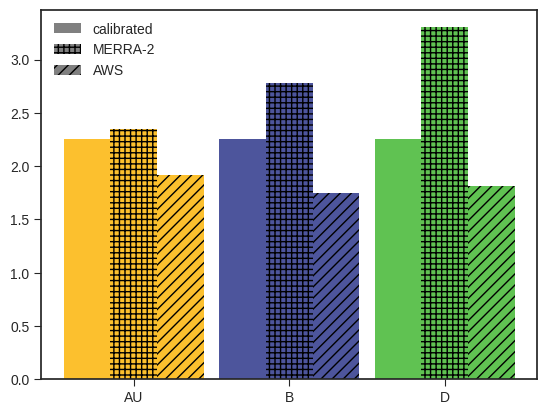

In [147]:
fig, ax = plt.subplots()
for s, site in enumerate(kp_by_site):
    if site != 'A':
        ax.bar(s, kp_by_site[site]['calibrated'], width=0.3,color=colors[s])
        ax.bar(s+0.3, kp_by_site[site]['MERRA-2_data'], width=0.3, hatch='+++', color=colors[s])
        ax.bar(s+0.6, kp_by_site[site]['AWS_data'], width=0.3, hatch='///', color=colors[s])
        
ax.bar(np.nan, np.nan, color='gray',label='calibrated')
ax.bar(np.nan, np.nan, color='gray',label='MERRA-2',hatch='+++')
ax.bar(np.nan, np.nan, color='gray',label='AWS', hatch='///')
ax.tick_params(length=5)
ax.set_xticks([1.3, 2.3, 3.3])
ax.set_xticklabels(['AU','B','D'])
ax.legend()
plt.show()

In [162]:
dd = []
for site in ['AU','B','D']:
    print(kp_by_site[site]['AWS_data'])
    dd.append(kp_by_site[site]['AWS_data'])
print(np.mean(dd))


1.912026013153925
1.7513193927077606
1.8174874473043963
1.826944284388694
